## Redes neuronais - classificação

In [157]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

**Carregar dados**

In [158]:
train_df = pd.read_csv("train_data_prepared.csv", encoding="latin-1", keep_default_na=False, na_values=['NULL', ''])
test_df = pd.read_csv("test_data_prepared.csv", encoding="latin-1", keep_default_na=False, na_values=['NULL', ''])

In [159]:
train_df.head()

,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,RAIN_INTENSITY,...,supermarket_peak_level,periodo_aulas,fim_de_semana,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos,congestion_ratio
0,41.5,11.5,71.4,2,15.0,1019.0,100.0,3.0,0,0,...,0,0,0,9.659258e-01,-0.258819,0.433884,-0.900969,-8.660254e-01,-5.000000e-01,0.161064
1,41.7,48.3,87.4,2,21.0,1021.0,53.0,5.0,1,0,...,1,0,0,-5.000000e-01,-0.866025,-0.433884,-0.900969,-8.660254e-01,-5.000000e-01,0.552632
2,38.6,38.4,85.2,2,26.0,1014.0,61.0,4.0,0,0,...,1,0,1,-8.660254e-01,-0.500000,-0.781831,0.623490,-1.000000e+00,-1.836970e-16,0.450704
3,37.4,61.0,94.1,2,18.0,1025.0,48.0,4.0,1,0,...,0,1,0,2.588190e-01,-0.965926,0.781831,0.623490,8.660254e-01,5.000000e-01,0.648247
4,41.6,50.4,77.0,2,15.0,1008.0,82.0,10.0,0,0,...,1,1,0,1.224647e-16,-1.000000,0.433884,-0.900969,1.224647e-16,-1.000000e+00,0.654545


**Separação entre variáveis (X) e alvo (y)**

In [160]:
X = train_df.drop(columns=["AVERAGE_SPEED_DIFF"]).values
y = train_df["AVERAGE_SPEED_DIFF"].values.astype(int)

In [161]:
y = np.array(y)

In [162]:
raw_weights = np.array([3.040, 5.055, 4.412, 5.488, 15.519], dtype=np.float32)
norm_weights = raw_weights / raw_weights.mean()
class_weights = torch.tensor(norm_weights, dtype=torch.float32)

print("Pesos normalizados:", class_weights)

Pesos normalizados: tensor([0.4535, 0.7542, 0.6582, 0.8188, 2.3153])


**Criação do modelo da MLP**

In [ ]:
class MLP(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()

        self.fc1 = nn.Linear(n_inputs, 64)
        self.drop1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(32, 5)  # 5 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        return self.fc3(x)  # CrossEntropyLoss aplica softmax internamente

**K-FOLD CROSS-VALIDATION**

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies, precisions, recalls, f1s = [], [], [], []
all_train_losses, all_val_losses = [], []

epochs = 9 # Número de epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== FOLD {fold+1} =====")

    # Dividir dados
    X_train, X_val = X[train_idx], X[val_idx]
    y_train_np, y_val_np = y[train_idx], y[val_idx]

    # Normalização
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Conversão para tensores
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
    y_val = torch.tensor(y_val_np, dtype=torch.long).to(device)

    # DataLoaders
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32)

    # Criar modelo
    model = MLP(n_inputs=X.shape[1]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_losses = [], []

    # Treino por epoch
    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validação
        model.eval()
        val_running_loss = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_running_loss += loss.item()

        val_losses.append(val_running_loss / len(val_loader))

    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

    # Métricas
    model.eval()
    y_pred_list = []

    with torch.no_grad():
        for xb, _ in val_loader:
            probs = model(xb)
            preds = probs.argmax(axis=1)
            y_pred_list.extend(preds.cpu().numpy())

    acc = accuracy_score(y_val_np, y_pred_list)
    prec = precision_score(y_val_np, y_pred_list, average="weighted", zero_division=0)
    rec = recall_score(y_val_np, y_pred_list, average="weighted", zero_division=0)
    f1 = f1_score(y_val_np, y_pred_list, average="weighted", zero_division=0)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)

    print(f"Accuracy Fold: {acc:.4f}")
    print(classification_report(y_val_np, y_pred_list))



Using device: cpu

===== FOLD 1 =====
Accuracy Fold: 0.7601
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       443
           1       0.67      0.61      0.63       299
           2       0.79      0.73      0.76       342
           3       0.72      0.71      0.71       202
           4       0.70      0.95      0.81        77

    accuracy                           0.76      1363
   macro avg       0.74      0.77      0.75      1363
weighted avg       0.76      0.76      0.76      1363


===== FOLD 2 =====
Accuracy Fold: 0.7806
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       462
           1       0.66      0.66      0.66       287
           2       0.77      0.82      0.79       298
           3       0.83      0.67      0.74       213
           4       0.71      0.92      0.81       103

    accuracy                           0.78      1363
   macro avg       0.77      

**Resultados finais da Cross-validation**

In [165]:
print("\n=======================")
print("RESULTADOS CROSS-VALIDATION")
print("=======================")
print(f"Accuracy média:  {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precisão média:  {np.mean(precisions):.4f}")
print(f"Recall médio:    {np.mean(recalls):.4f}")
print(f"F1-score médio:  {np.mean(f1s):.4f}")


RESULTADOS CROSS-VALIDATION
Accuracy média:  0.7772 ± 0.0115
Precisão média:  0.7775
Recall médio:    0.7772
F1-score médio:  0.7757


**Gráfico de loss**

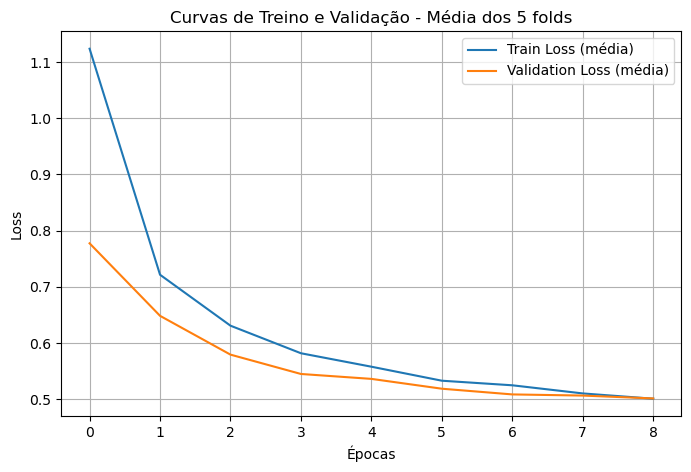

In [166]:
mean_train_loss = np.mean(all_train_losses, axis=0)
mean_val_loss = np.mean(all_val_losses, axis=0)

plt.figure(figsize=(8,5))
plt.plot(mean_train_loss, label="Train Loss (média)")
plt.plot(mean_val_loss, label="Validation Loss (média)")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.title("Curvas de Treino e Validação - Média dos 5 folds")
plt.legend()
plt.grid()
plt.show()


**Treino final com todo o dataset**

In [ ]:
print("\n=======================")
print("TREINO FINAL COM TODO O DATASET")
print("=======================\n")

# Preparar X e y completos
X_full = train_df.drop(columns=["AVERAGE_SPEED_DIFF"]).values
y_full = train_df["AVERAGE_SPEED_DIFF"].values.astype(int)

# Normalizar todo o dataset de treino
scaler_final = StandardScaler()
X_full = scaler_final.fit_transform(X_full)

# Converter para tensores
X_full = torch.tensor(X_full, dtype=torch.float32).to(device)
y_full = torch.tensor(y_full, dtype=torch.long).to(device)

full_loader = DataLoader(TensorDataset(X_full, y_full), batch_size=32, shuffle=True)

# modelo final
model_final = MLP(n_inputs=X.shape[1]).to(device)
criterion_final = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_final = torch.optim.Adam(model_final.parameters(), lr=0.001)

epochs_final = 9

# Treino
for epoch in range(epochs_final):
    model_final.train()
    running_loss = 0

    for xb, yb in full_loader:
        optimizer_final.zero_grad()
        preds = model_final(xb)
        loss = criterion_final(preds, yb)
        loss.backward()
        optimizer_final.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs_final} - Loss: {running_loss / len(full_loader):.4f}")

print("\nTreino final concluído!\n")



TREINO FINAL COM TODO O DATASET

Epoch 1/9 - Loss: 1.0860
Epoch 2/9 - Loss: 0.6964
Epoch 3/9 - Loss: 0.6067
Epoch 4/9 - Loss: 0.5663
Epoch 5/9 - Loss: 0.5447
Epoch 6/9 - Loss: 0.5273
Epoch 7/9 - Loss: 0.5135
Epoch 8/9 - Loss: 0.5044
Epoch 9/9 - Loss: 0.4980

Treino final concluído!



**Previsões finais no test set**

In [ ]:
print("A gerar predições finais...")

X_test = test_df.values
X_test = scaler_final.transform(X_test)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

model_final.eval()
y_test_pred = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor), 32):
        batch = X_test_tensor[i:i+32]
        logits = model_final(batch)
        preds = logits.argmax(axis=1)
        y_test_pred.extend(preds.cpu().numpy())

# Mapeamento inverso
reverse_mapping = {
    0: "None",
    1: "Low",
    2: "Medium",
    3: "High",
    4: "Very_High"
}

y_test_labels = pd.Series(y_test_pred).map(reverse_mapping)


A gerar predições finais...


**Gerar ficheiro de submissão para o Kaggle**

In [169]:
submission = pd.DataFrame({
    "RowId": range(1, len(test_df) + 1),
    "Speed_Diff": y_test_labels
})

submission.to_csv("submission.csv", index=False)

print("\n=========================================")
print("Ficheiro 'submission.csv' criado com sucesso!")
print("=========================================\n")


Ficheiro 'submission.csv' criado com sucesso!



Accuracy no Kaggle: 0.76000